# Results: round 2

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize

import seaborn as sns
import plotly.express as px

import numpy as np
import pandas as pd
import polars as pl

import statsmodels.formula.api as smf
import statsmodels.api as sm

import matplotlib

## Fisher information controls

What does the Fisher information of un-trained and uniform-trained neural networks look like?

In [2]:
from discriminationAnalysis import Fisher_smooth_fits
from basicModel import EstimateAngle

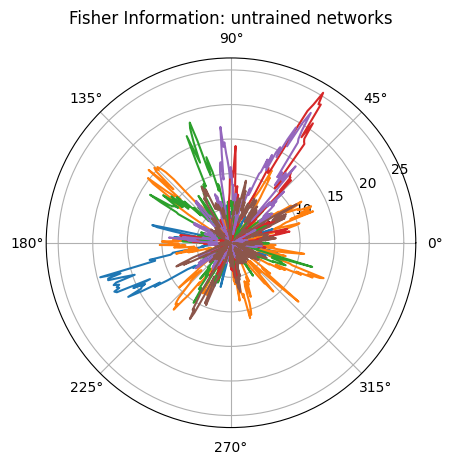

In [4]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.title('Fisher Information: untrained networks')

ex4_dir = 'trainedParameters/Exp4/'

for rep in range(6):
    model = EstimateAngle.load_from_checkpoint(ex4_dir + \
                                            f'rep{rep}/pretrain.ckpt')
    fi = Fisher_smooth_fits(model, 0., np.pi, N_cov=500, Samp_cov=500)
    plt.plot(np.linspace(0, 2*np.pi, 500), fi)

The untrained Fisher information is small everywhere. There is some noise but, for the most part, everything is fairly close to zero.

This is totally reasonable: the emedding is basically nowhere aligned with the stimulus dimension.

(Note that this plot has the angle doubled.)

/usr/local/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.1.2


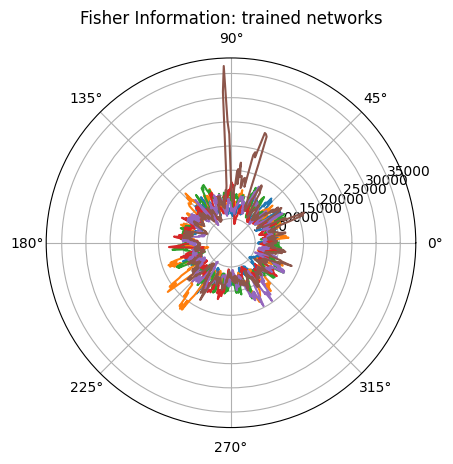

In [6]:
import glob

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.title('Fisher Information: trained networks')

ex4_dir = 'trainedParameters/Exp4/'

FIcurves = []

for rep in range(6):
    trained_ckpt =  glob.glob('trainedParameters/Exp4/' + f'rep{rep}/epoch*')[0]
    
    model = EstimateAngle.load_from_checkpoint(trained_ckpt)

    fi = Fisher_smooth_fits(model, 0., np.pi, N_cov=500, Samp_cov=500)
    FIcurves.append(fi)
    
    plt.plot(np.linspace(0, 2*np.pi, 500), fi)

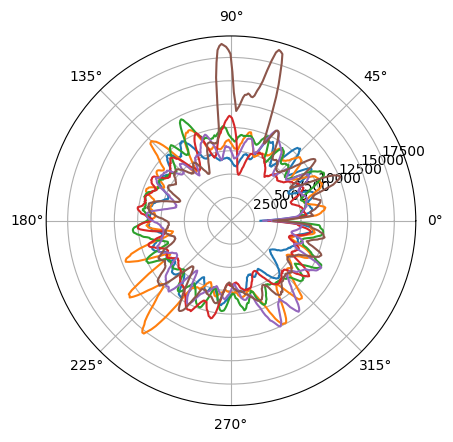

In [31]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

for i in range(6):
    plt.plot(np.linspace(0, 2*np.pi, 500),
             np.convolve(FIcurves[i], np.ones(10), mode='same')/10)

Ok, here we see a difficulty for convergence: there is significant homogenity in the Fisher information.

- note that the drop near zero is due to edge effects in the convolution. Need to fix this.

It certainly appears that brown and orange curves randomly learned heightened sensitivity at some places.

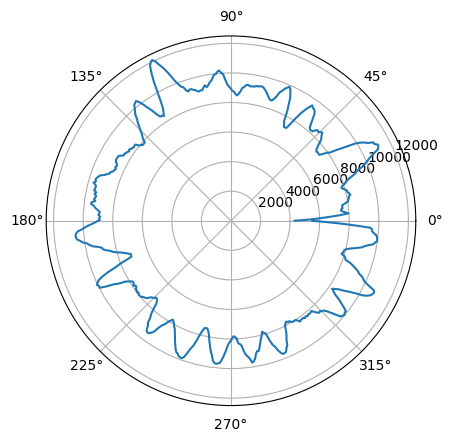

In [63]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot(np.linspace(0, 2*np.pi, 500),
             np.convolve(FIcurves[2], np.ones(10)/10, mode='same'))

In [62]:
np.convolve(FIcurves[2], np.ones(10)/10, mode='valid').min()

7139.4125059326725

In [53]:
np.convolve(FIcurves[2], np.ones(10)/10, mode='valid').max()

12110.173215138537

Even in this relatively smooth looking example, there is still a large variation in the Fisher information!

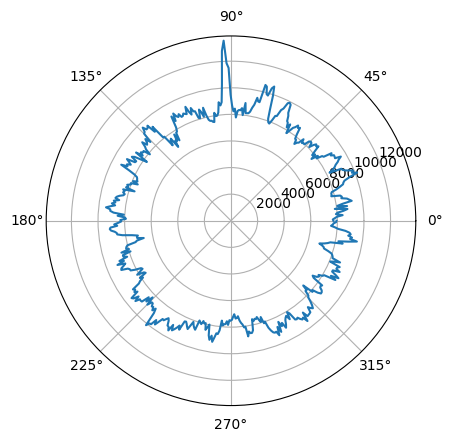

In [67]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

plt.plot(np.linspace(0, 2*np.pi, 500),np.mean(FIcurves, axis=0))

Averaging over the 6 repeats gives relatively smooth outputs

In [71]:
np.mean(FIcurves, axis=0).max()

13555.331280948822

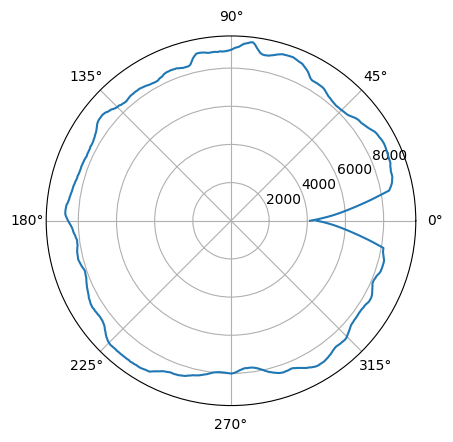

In [76]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot(np.linspace(0, 2*np.pi, 500),
         np.convolve(np.mean(FIcurves, axis=0), np.ones(30)/30, mode='same') )

Averaging and smoothing heavily, we recover something that seems reasonable constant (again, we eventually have to correct for the the edge effects).

Q: Does this work for a concentrated distribution?

Based on the results in notebook: Experiments 5, the answer should be yes.

/usr/local/lib/python3.9/site-packages/pytorch_lightning/utilities/migration/utils.py:55: The loaded checkpoint was produced with Lightning v2.2.1, which is newer than your current Lightning version: v2.1.2


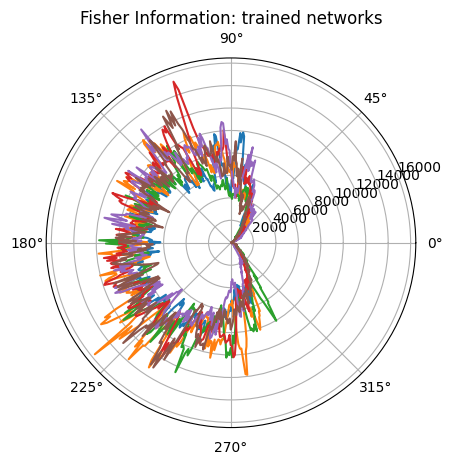

In [79]:
import glob

fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.title('Fisher Information: trained networks')

ex4_conc_dir = 'trainedParameters/Exp4_conc/'

FIcurves_conc = []

for rep in range(6):
    trained_ckpt =  glob.glob(ex4_conc_dir + f'rep{rep}/epoch*')[0]
    
    model = EstimateAngle.load_from_checkpoint(trained_ckpt)

    fi = Fisher_smooth_fits(model, 0., np.pi, N_cov=500, Samp_cov=500)
    FIcurves_conc.append(fi)
    
    plt.plot(np.linspace(0, 2*np.pi, 500), fi)

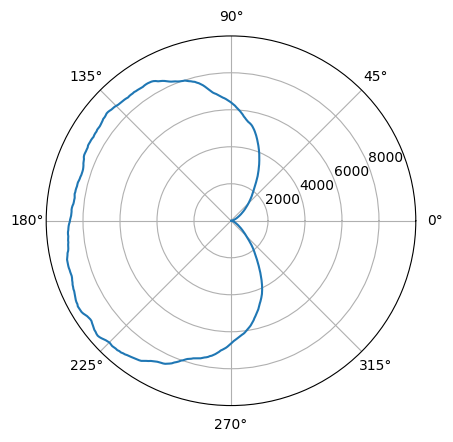

In [80]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})
plt.plot(np.linspace(0, 2*np.pi, 500),
         np.convolve(np.mean(FIcurves_conc, axis=0), np.ones(30)/30, mode='same') )

Ok, this is unfortunately mixed up i the decaying edge effect from the convolution, but the difference from the previous example is clear.

In [297]:
np.convolve(np.mean(FIcurves, axis=0), np.ones(30)/30, mode='same')[30:-30].max() -\
np.convolve(np.mean(FIcurves, axis=0), np.ones(30)/30, mode='same')[30:-30].min()

1663.2404903463075

In [306]:
np.convolve(np.mean(FIcurves_conc, axis=0), np.ones(30)/30, mode='same')[30:-30].max() - \
np.convolve(np.mean(FIcurves_conc, axis=0), np.ones(30)/30, mode='same')[30:-30].min()

9307.780735362396

One possible method for detecting non-constant Fisher information is a simple max to min threasholding.

## Behavior: fine-tuning under distribution shift

In [157]:
results = pd.read_csv('experiment_result/ex5_scan_optimal.csv')

# all kappa values are the same
results = results.drop(['kappa', 'kappa_init'], axis=1)


In [158]:
initial_train = results[results['rep_init'].isna()]
fine_tune = results[ ~results['rep_init'].isna() ]

In [159]:
initial_train = initial_train.drop(['rep_init', 'datasize_init', 'loc_init'], axis=1)

In [163]:
collected = fine_tune.merge(initial_train, 
                  left_on=['rep_init', 'datasize_init', 'loc_init'],
                  right_on=['rep', 'datasize', 'loc'],
                  suffixes=('_ft', '_pre')
              )

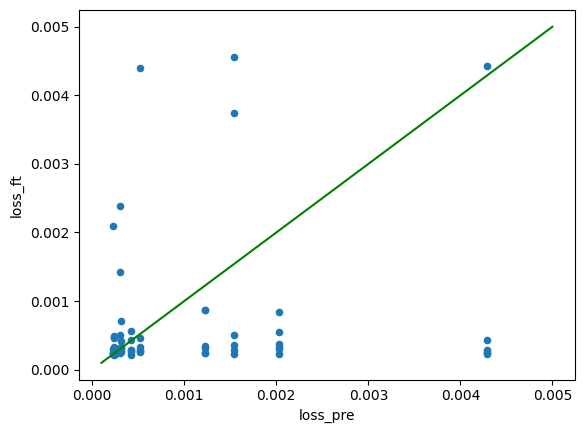

In [182]:
collected.plot.scatter('loss_pre', 'loss_ft')
plt.plot(np.linspace(0.0001, 0.005), np.linspace(0.0001, 0.005), '-g')

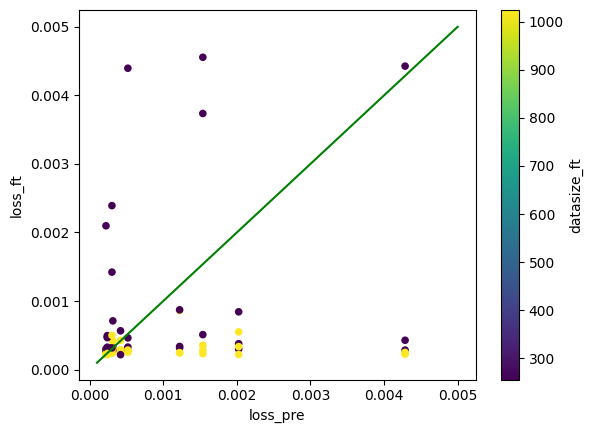

In [184]:
collected.plot.scatter('loss_pre', 'loss_ft', c='datasize_ft', cmap='viridis')
plt.plot(np.linspace(0.0001, 0.005), np.linspace(0.0001, 0.005), '-g')

The examples that see large additional loss due to finetuning are all using small finetuning sizes.

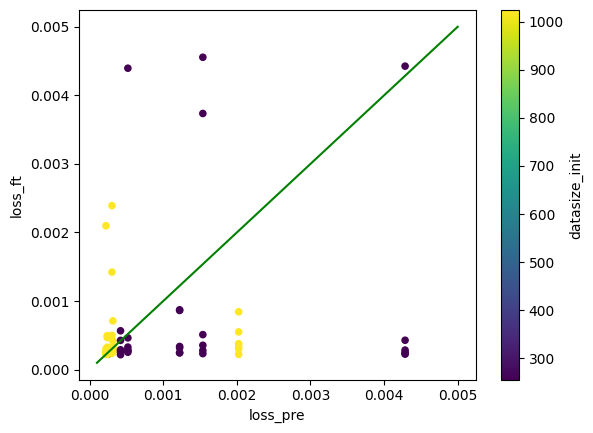

In [185]:
collected.plot.scatter('loss_pre', 'loss_ft', c='datasize_init', cmap='viridis')
plt.plot(np.linspace(0.0001, 0.005), np.linspace(0.0001, 0.005), '-g')

The most egregious losses interestingly also have small initial training set sizes.

However, large training sets are also represented at medium frequencies.

In [210]:
collected['ratio'] = collected['loss_ft'] / collected['loss_pre']

<Axes: xlabel='index', ylabel='ratio'>

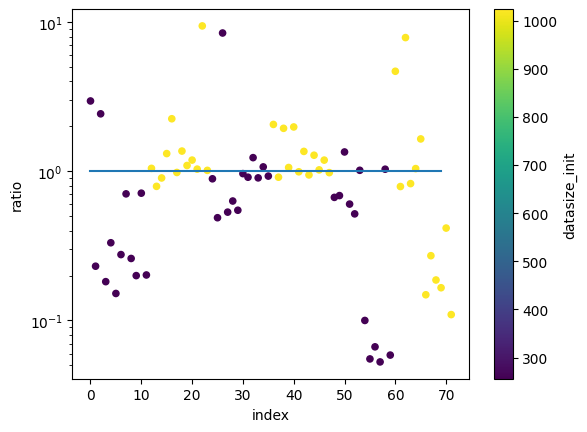

In [218]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_yscale('log')
ax.plot(np.arange(70), np.ones(70))


collected = collected.sort_values('datasize_ft')
collected.reset_index().plot.scatter('index', 'ratio', ax=ax, c='datasize_init', cmap='viridis')


<Axes: xlabel='index', ylabel='ratio'>

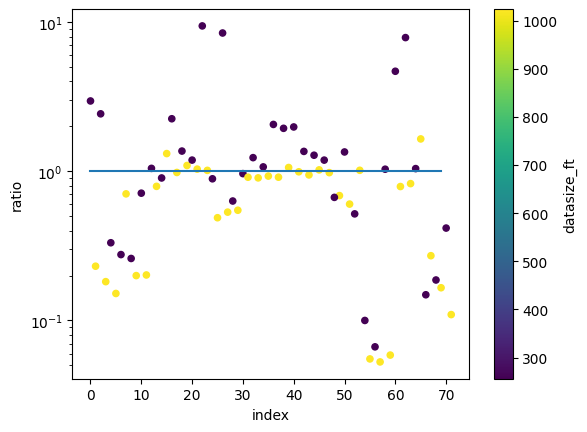

In [222]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_yscale('log')
ax.plot(np.arange(70), np.ones(70))


collected = collected.sort_values('loc_init')
collected.reset_index().plot.scatter('index', 'ratio', ax=ax, c='datasize_ft', cmap='viridis')


In [223]:
collected['size_ratio'] = collected['datasize_ft'] / collected['datasize_init']

<Axes: xlabel='index', ylabel='ratio'>

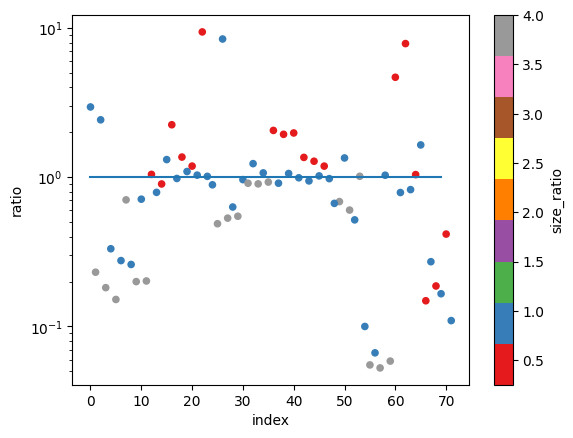

In [243]:
fig = plt.figure()
ax = fig.add_subplot()
ax.set_yscale('log')
ax.plot(np.arange(70), np.ones(70))


collected = collected.sort_values('loc_init')
collected.reset_index().plot.scatter('index', 'ratio', ax=ax, c='size_ratio', colormap='Set1')


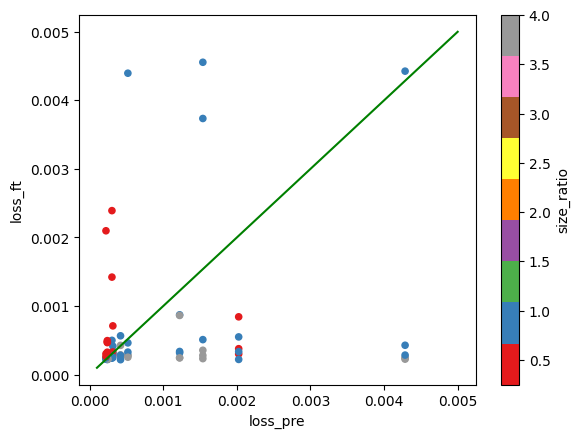

In [244]:
collected.plot.scatter('loss_pre', 'loss_ft', c='size_ratio', colormap='Set1')
plt.plot(np.linspace(0.0001, 0.005), np.linspace(0.0001, 0.005), '-g')

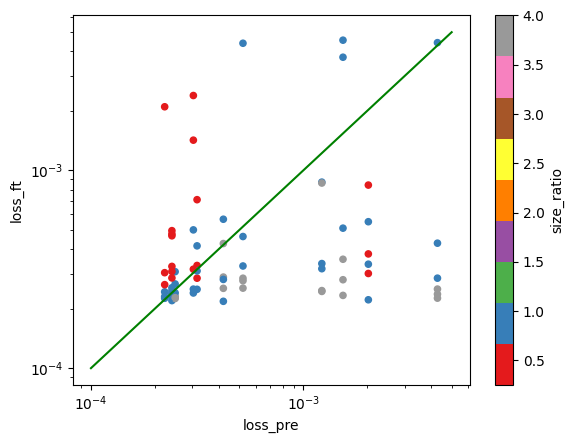

In [245]:
collected.plot.scatter('loss_pre', 'loss_ft', c='size_ratio', colormap='Set1', logx=True, logy=True)
plt.plot(np.linspace(0.0001, 0.005), np.linspace(0.0001, 0.005), '-g')

Ok, so, what does this show me?
1. size ratio is really a key determinant: greater than 1 -> only improvement, less than one -> usually decrease, at 1 random improvement vs decrease

In [249]:
initial_train[ initial_train['datasize'] == 256]['loss'].mean()

0.0013727449113502502

In [252]:
fine_tune[fine_tune['datasize'] == 256]['loss'].mean()

0.0009596047586657472

In [266]:
fine_tune[(fine_tune['datasize'] == 256) & (fine_tune['datasize_init'] == 256)]['loss'].mean()

0.0012521092689388668

In [257]:
initial_train[ initial_train['datasize'] == 1024]['loss'].mean()

0.0005581010336754333

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/boxplots.py:183: RuntimeWarning: invalid value encountered in divide
  violin = width * violin / violin.max()


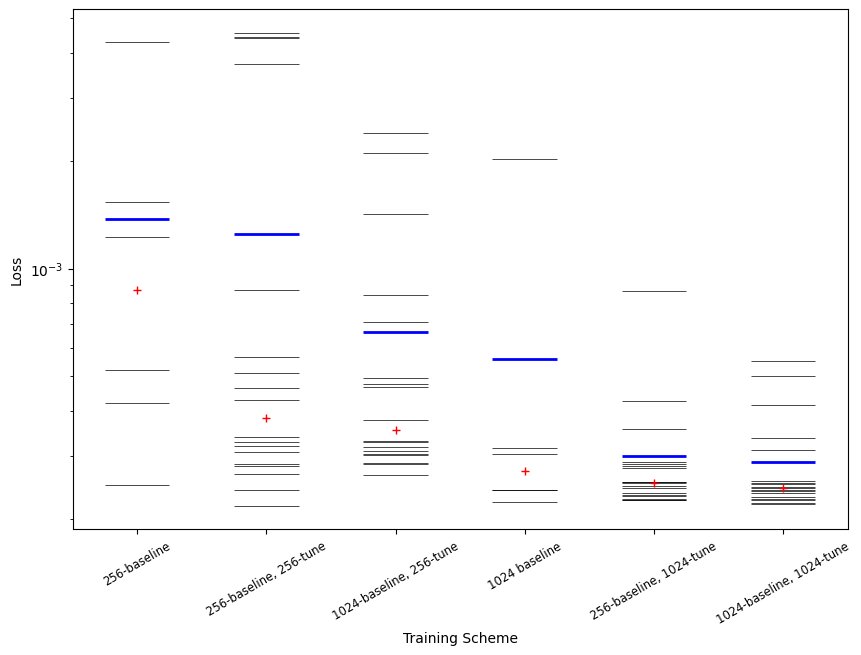

In [288]:
data = sm.datasets.anes96.load_pandas()
party_ID = np.arange(7)
labels = [
    "256-baseline",
    "256-baseline, 256-tune",
    "1024-baseline, 256-tune",
    "1024 baseline",
    "256-baseline, 1024-tune",
    "1024-baseline, 1024-tune"
]


bins = [initial_train[ initial_train['datasize'] == 256]['loss'],
        fine_tune[(fine_tune['datasize'] == 256) & (fine_tune['datasize_init'] == 256)]['loss'],
        fine_tune[(fine_tune['datasize'] == 256) & (fine_tune['datasize_init'] == 1024)]['loss'],
        initial_train[ initial_train['datasize'] == 1024]['loss'],
        fine_tune[(fine_tune['datasize'] == 1024) & (fine_tune['datasize_init'] == 256)]['loss'],
        fine_tune[(fine_tune['datasize'] == 1024) & (fine_tune['datasize_init'] == 1024)]['loss'],
        ]

plt.rcParams["figure.subplot.bottom"] = 0.23  # keep labels visible
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # make plot larger in notebook

fig = plt.figure()
ax = fig.add_subplot(111)
plot_opts = {
    "cutoff_val": 5,
    "cutoff_type": "abs",
    "label_fontsize": "small",
    "label_rotation": 30,
}
sm.graphics.beanplot(bins, ax=ax, labels=labels, plot_opts=plot_opts)
ax.set_xlabel("Training Scheme")
ax.set_ylabel("Loss")
ax.set_yscale('log')

## !! Important note about the above

While going back through the code, I found out that I wasn't really fine-tuning anything! The 'finetune' runs were actually totally de-novo.

All of the data above represents noise, except between 256 training points (either 256-baseline or *baseline, 256-tune) and 1024 points. 

I hindsight, I was too hasty to read into an apparent trend. The correct conclusion is that (in this data) there is no effect from 'baseline training' (after all, it didn't occur). That the loss decreases is almost certainly not significant.


## Second run of the experiment: freezing the lower layers of the network.

In [27]:
data = pd.read_csv('experiment_result/ex5_scan_freeze.csv')

In [28]:
data

,rep,datasize,loc,kappa,rep_init,datasize_init,loc_init,kappa_init,loss
0,0,256,0.000000,8.0,NaN,NaN,NaN,NaN,0.000350
1,0,256,1.570796,8.0,0.0,256.0,0.000000,8.0,0.000313
2,0,1024,1.570796,8.0,0.0,256.0,0.000000,8.0,0.000245
3,1,256,1.570796,8.0,0.0,256.0,0.000000,8.0,0.000322
4,1,1024,1.570796,8.0,0.0,256.0,0.000000,8.0,0.000248
5,2,256,1.570796,8.0,0.0,256.0,0.000000,8.0,0.000258
6,2,1024,1.570796,8.0,0.0,256.0,0.000000,8.0,0.000248
7,0,256,1.570796,8.0,NaN,NaN,NaN,NaN,0.000289
8,0,256,0.000000,8.0,0.0,256.0,1.570796,8.0,0.000289
9,0,1024,0.000000,8.0,0.0,256.0,1.570796,8.0,0.000231


Bean plots for a couple of orthogonal groupings

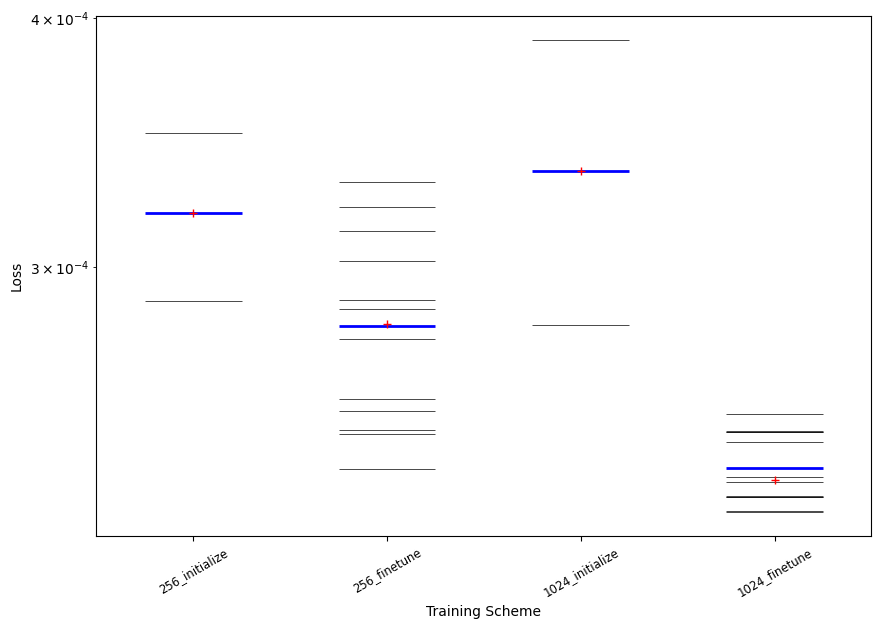

In [30]:
size_256 = data[ data.datasize == 256]
size_1024 = data[ data.datasize ==1024]

init_256 = size_256[size_256.rep_init.isna()]
ft_256 = size_256[~size_256.rep_init.isna()]

init_1024 = size_1024[size_1024.rep_init.isna()]
ft_1024 = size_1024[~size_1024.rep_init.isna()]

labels = [
    "256_initialize",
    "256_finetune",
    "1024_initialize",
    "1024_finetune"
]


bins = [init_256['loss'],
        ft_256['loss'],
        init_1024['loss'],
        ft_1024['loss']
        ]

plt.rcParams["figure.subplot.bottom"] = 0.23  # keep labels visible
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # make plot larger in notebook

fig = plt.figure()
ax = fig.add_subplot(111)
plot_opts = {
    "cutoff_val": 5,
    "cutoff_type": "abs",
    "label_fontsize": "small",
    "label_rotation": 30,
}
sm.graphics.beanplot(bins, ax=ax, labels=labels, plot_opts=plot_opts)
ax.set_xlabel("Training Scheme")
ax.set_ylabel("Loss")
ax.set_yscale('log')

/usr/local/lib/python3.9/site-packages/statsmodels/graphics/boxplots.py:183: RuntimeWarning: invalid value encountered in divide
  violin = width * violin / violin.max()


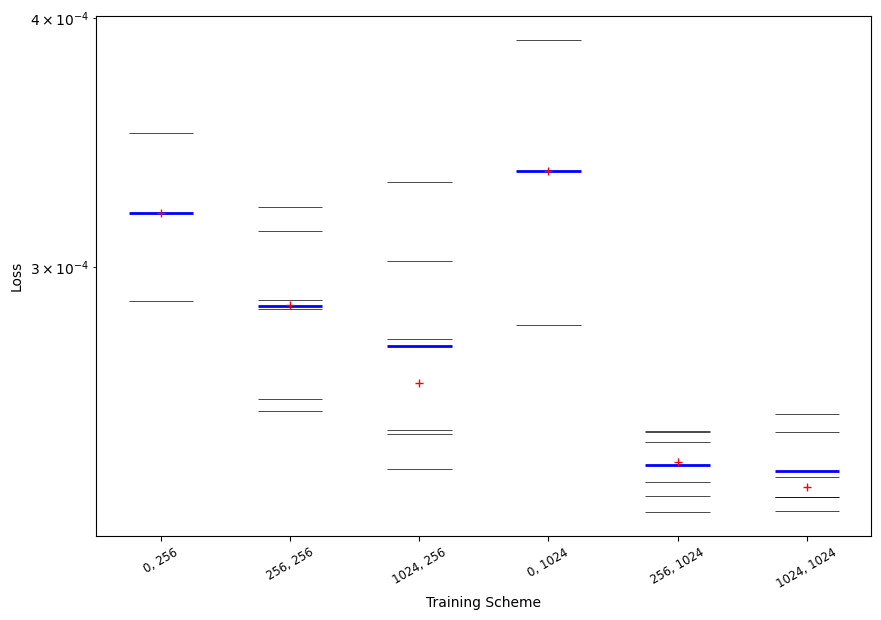

In [33]:
size_256 = data[ data.datasize == 256]
size_1024 = data[ data.datasize ==1024]

init_256 = size_256[size_256.rep_init.isna()]
ft_256 = size_256[~size_256.rep_init.isna()]

init_1024 = size_1024[size_1024.rep_init.isna()]
ft_1024 = size_1024[~size_1024.rep_init.isna()]

labels = [
    "0, 256",
    "256, 256",
    "1024, 256",
    "0, 1024",
    "256, 1024",
    "1024, 1024"
]


bins = [data[(data.datasize == 256) & (data.datasize_init.isna())].loss,
        data[(data.datasize == 256) & (data.datasize_init == 256)].loss,
        data[(data.datasize == 256) & (data.datasize_init == 1024)].loss,
        data[(data.datasize == 1024) & (data.datasize_init.isna())].loss,
        data[(data.datasize == 1024) & (data.datasize_init == 256)].loss,
        data[(data.datasize == 1024) & (data.datasize_init == 1024)].loss,
        ]

plt.rcParams["figure.subplot.bottom"] = 0.23  # keep labels visible
plt.rcParams["figure.figsize"] = (10.0, 8.0)  # make plot larger in notebook

fig = plt.figure()
ax = fig.add_subplot(111)
plot_opts = {
    "cutoff_val": 5,
    "cutoff_type": "abs",
    "label_fontsize": "small",
    "label_rotation": 30,
}
sm.graphics.beanplot(bins, ax=ax, labels=labels, plot_opts=plot_opts)
ax.set_xlabel("Training Scheme")
ax.set_ylabel("Loss")
ax.set_yscale('log')

I mean, its basically the same as  before.

Probably the only significant difference is between 1024 finetuning and 256 finetuning... Even then, its a small effect.

Another (low significance) effect that is interesting to note is 1024, 256 versus 256, 1024.
In this case, we have the same total number of points, so that is constant. More finetuning is better (as more training is better). Probably with the same significance as 256 total vs 1024 total.

#### I think this problem is too easy: it doesn't run into network constraints. Gotta make the problem harder or the network smaller.